#  알고리즘 공부

## YOLOv3 연습

In [1]:
# 모듈로딩
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time # 프레임 계산을 위해 사용

In [13]:
# YOLO로드 => yolo 포맷 및 클래스명 불러오기
net=cv2.dnn.readNet('yolov3.weights','yolov3.cfg') # 네트워크 불러오기
## 1. dnn이란 deep neural network로 모듈

# GPU 사용
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

# YOLO에 저장된 클래스 종류
classes=[]
with open('coco.names','r') as f: # coco.names의 파일 안에는 다양한 종류의 클래스가 있음
    classes=[line.strip() for line in f.readlines()]

# YOLO 클래스 확인
print(f'파일에 저장되어 있는 클래스 종류\n {classes}\n 종류의 개수={len(classes)}')

# YOLO의 layer확인
layer_names=net.getLayerNames() # 네트워크의 모든 레이어 이름을 가지고 옴 => conv_0, conv_26 등등
output_layers=[layer_names[i-1] for i in net.getUnconnectedOutLayers()]
## 1. net.getUnconnectedOutLayers() : 출력레이어 가져오기
## 2. i-1부분은 출처에는 i[0]-1라고 되어 있는데 오류가 나오는데 왜 [0]을 해줘야 할까??
## 3. YOLO에눈 3개의 출력 레이어가 있음 => 82/94/106

# 랜덤으로 색 지정하기 => RGB
colors=np.random.uniform(0,255,size=(len(classes),3))
## 1. 80행 3열로 된 0~255인 균일분포의 값을 랜덤 추출

파일에 저장되어 있는 클래스 종류
 ['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
 종류의 개수=80


In [14]:
# 이미지 불러오기
img=cv2.imread('busuksa2.jpg')
## 1. 이미지를 불러와 배열 형태로 저장 => 배열구조는 (1080,1920,3)
## 2. 'C:/Users/USER/Desktop/com_project/data/rawdata/C/[emergency]accident12_055C/[emergency]accident12_055C_840.jpg'
# img=cv2.resize(img,(516,516),fx=0.4,fy=0.4)
# ## 1. 불러온 이미지 사이즈 변경 => 배열구조는 (516,516,3)
height,width,channels=img.shape
## 1. height=1920/ width=1080/ channels=3

In [4]:
# 객체 탐지
blob = cv2.dnn.blobFromImage(img, 0.00392, (608, 608), (0, 0, 0), True, crop=False)
## 1. 크기는 320/416/608 3개가 있음
## 2. blobFromImage로 이미지 전처리하고 blob에 전달
## 3. blob형식은 Mat타입의 4차원(4D Tensor:NCHW) 행렬 => N(영상개수) C(채널 개수) H(영상 세로) W(영상 가로)
net.setInput(blob) # 생성된 blob객체로 네트워크 입력으로 설정
outs = net.forward(output_layers) # 네트워크를 순방향으로 실행하여 결과를 예측

In [5]:
# 바운딩 박스 죄표 찾기
class_ids = [] # class종류 인덱스
confidences = [] # 신뢰도
boxes = [] # 바운딩 박스의 4개 좌표

for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores) # 최대값 인덱스 추출
        confidence = scores[class_id] # 신뢰도

        if class_id==0 and confidence > 0.5:
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

In [6]:
# 노이즈 제거
indexes = cv2.dnn.NMSBoxes(boxes, confidences,0.5,0.4)
## 1. NMS은 비최대억제로 최대값을 찾아 그값만 남기고 나머지 값은 모두 삭제하는 알고리즘
## 2. object detector가 예측한 바운딩 박스 중에서 정확한 바운딩박스를 선택하도록하는 기법
## 3. 겹쳐있는 박스중에 상자가 물체일 확률이 가장 높은 박스만 남겨둠

In [7]:
# 화면에 표시
font = cv2.FONT_HERSHEY_PLAIN # 작은 크기 산세리프 폰트
boxes_index=[] # 비최대 억제값으로 제거된 라운딩 박스를 제거

for i in range(len(boxes)):
    if i in indexes:
        boxes_index.append(boxes[i]) # 살아남은 라운딩 박스 좌표값만 들어감
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        color = colors[i]
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2) # 직사각형=>라운딩 박스
        cv2.putText(img, label, (x, y + 30), font, 3, color, 3) # 라운딩 박스 옆에 객체 이름 표시

# print(boxes_index) # 바운딩 박스 좌표값 출력
cv2.imshow("Image", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [8]:
# 한글 폰트
from matplotlib import font_manager,rc
font_path= 'C:/Windows/Fonts/malgun.ttf'
font=font_manager.FontProperties(fname=font_path).get_name()
rc('font',family=font)

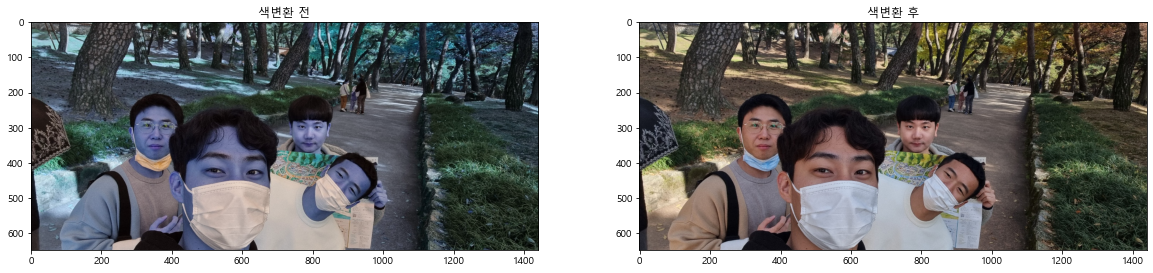

In [9]:
# 이미지를 불러와서 색변환 시키기
img=cv2.imread('busuksa2.jpg')
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('색변환 전')
img=cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
plt.subplot(1,2,2)
plt.imshow(img)
plt.title('색변환 후')
plt.show()

In [10]:
# 객체 찾기 함수
def dect_person(path):
    # 이미지 불러오기
    img=cv2.imread(path)
    # img=cv2.resize(img,(850,850),fx=0.4,fy=0.4)
    height,width,channels=img.shape

    # 객체 탐지
    blob = cv2.dnn.blobFromImage(img, 0.00392, (608, 608), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    # 바운딩 박스 죄표 찾기
    class_ids = []
    confidences = [] 
    boxes = [] 

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if class_id==0 and confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    
    # 노이즈 제거
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    # 화면에 표시
    font = cv2.FONT_HERSHEY_PLAIN
    boxes_index=[] 

    for i in range(len(boxes)):
        if i in indexes:
            boxes_index.append(boxes[i]) 
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = colors[i]
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 2) 
            cv2.putText(img, label, (x, y + 30), font, 3, color, 3)

    print(boxes_index)
    cv2.imshow("Image", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [11]:
# 부석사 이미지(feat. 동생들)
dect_person('busuksa1.jpg')

[[16, 505, 926, 928], [530, 671, 329, 598], [820, 655, 265, 755]]


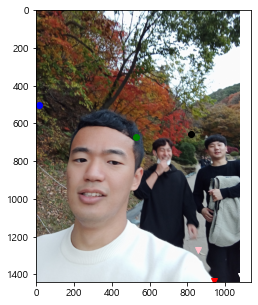

In [15]:
img=cv2.imread('busuksa1.jpg')
img=cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
plt.figure(figsize=(20,5))
plt.imshow(img)
plt.plot(16,505,'bo')
plt.plot(16+926,505+928,'rv')
plt.plot(530,671,'go')
plt.plot(530+329,671+598,color='pink',marker='v')
plt.plot(820,655,color='black',marker='o')
plt.plot(820+265,655+755,color='w',marker='v')

In [16]:
# 부석사 이미지(feat. 동생들)
dect_person('busuksa2.jpg')

[[77, 207, 379, 431], [651, 197, 328, 455], [397, 256, 292, 387], [870, 164, 35, 89], [907, 158, 49, 100]]


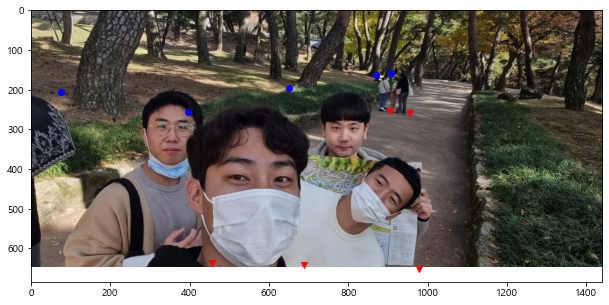

In [17]:
img=cv2.imread('busuksa2.jpg')
img=cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
plt.figure(figsize=(20,5))
plt.imshow(img)
plt.plot(77,207,'bo')
plt.plot(77+379,207+431,'rv')
plt.plot(651,197,'bo')
plt.plot(651+328,197+455,'rv')
plt.plot(397,256,'bo')
plt.plot(397+292,256+387,'rv')
plt.plot(870,164,'bo')
plt.plot(870+35,164+89,'rv')
plt.plot(907,158,'bo')
plt.plot(907+49,158+100,'rv')

In [19]:
# 부석사 이미지(feat. 일반사람들)
dect_person('busuksa3.jpg')

[[1099, 681, 271, 125], [677, 567, 40, 96], [713, 565, 41, 91], [743, 589, 43, 80], [747, 652, 43, 137], [693, 652, 48, 150], [787, 657, 62, 149]]


In [20]:
# 부석사 이미지(feat. 동생들)
dect_person('busuksa4.jpg')

[[437, 267, 246, 560], [688, 255, 237, 560]]


In [47]:
# ai_hub 이미지1
dect_person('C:/Users/USER/Desktop/com_project/data/rawdata/C/[emergency]accident12_055C/[emergency]accident12_055C_540.jpg')

[[1399, 256, 278, 436], [455, 343, 164, 259], [1092, 375, 214, 300]]


In [48]:
# ai_hub 이미지2
dect_person('C:/Users/USER/Desktop/com_project/data/rawdata/C/[emergency]accident12_055C/[emergency]accident12_055C_840.jpg')

[[910, 240, 303, 596], [948, 488, 176, 299]]


In [49]:
# ai_hub 이미지3
dect_person('C:/Users/USER/Desktop/com_project/data/rawdata/E/[emergency]accident12_055E/[emergency]accident12_055E_810.jpg')

[[573, 480, 147, 187]]


## 탐지객체를 사람만 한정함

In [21]:
min_confidence = 0.5

def detectAndDisplay(frame):
    start_time = time.time()
    img = cv2.resize(frame, None, fx=0.8, fy=0.8)
    height, width, channels = img.shape
    # cv2.imshow("Original Image", img)

    # 이미지 전처리 => blob객체
    blob = cv2.dnn.blobFromImage(img, 0.00392, (608, 608), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    # 탐지한 객체의 클래스 예측 
    class_ids = []
    confidences = []
    boxes = []

    # 라운딩 박스 찾기
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            
            if class_id == 0 and confidence > min_confidence: # class_id가 0이라는 것은 person임
                # 탐지한 객체 박싱
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # 노이즈 제거 
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, min_confidence, 0.4)

    # 폰트 설정
    font = cv2.FONT_HERSHEY_DUPLEX

    # 노이즈 제거된 라운딩 박스만 뽑아서 다시 리스트 좌표 만들기
    boxes_index=[]

    for i in range(len(boxes)):
        if i in indexes:
            boxes_index.append(boxes[i])
            x, y, w, h = boxes[i]
            label = f"{classes[class_ids[i]]}: {confidences[i]*100:.2f}"
            # print(i, label)
            color = colors[i]
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
            cv2.putText(img, label, (x, y - 5), font, 1, color, 1)
            
    end_time = time.time()
    process_time = end_time - start_time # 하나의 프레임을 탐지하는데 걸린 시간
    print(f"A frame took {process_time:.3f} seconds")
    cv2.imshow("YOLO test", img)

In [22]:
# 비디오 활성화
vedio_path = 'test.mp4' # 사용할 영상 경로

cap = cv2.VideoCapture(vedio_path)
if not cap.isOpened:
    print('(!)Error opening video capture')
    exit(0)
while True:
    ret, frame = cap.read()
    if frame is None:
        print('(!)No captured frame Break!')
        break
    detectAndDisplay(frame)
    # q 입력시 종료
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()

(!)No captured frame Break!


In [52]:
# 캠 활성화
cap = cv2.VideoCapture(0)
if not cap.isOpened:
    print('(!)Error opening video capture')
    exit(0)
while True:
    ret, frame = cap.read()
    if frame is None:
        print('(!)No captured frame Break!')
        break
    detectAndDisplay(frame)
    # q 입력시 종료
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()

A frame took 1.197 seconds
A frame took 1.145 seconds
A frame took 1.159 seconds
A frame took 1.088 seconds
A frame took 1.125 seconds
A frame took 1.124 seconds
A frame took 1.125 seconds
A frame took 1.165 seconds
A frame took 1.097 seconds
A frame took 1.148 seconds
A frame took 1.173 seconds
A frame took 1.167 seconds
A frame took 1.124 seconds
A frame took 1.094 seconds
A frame took 1.279 seconds
A frame took 1.382 seconds
A frame took 1.293 seconds
A frame took 1.379 seconds
A frame took 1.319 seconds
A frame took 1.405 seconds
A frame took 1.259 seconds
A frame took 1.474 seconds
A frame took 1.275 seconds
A frame took 1.437 seconds
A frame took 1.313 seconds
A frame took 1.525 seconds
A frame took 1.458 seconds
A frame took 1.378 seconds


## openpose 공부

In [53]:
# 사이트에 있는 코드 복사
# 출처 : https://bskyvision.com/entry/pythonopenpose-openpose-%EB%9D%BC%EC%9D%B4%EB%B8%8C%EB%9F%AC%EB%A6%AC%EB%A5%BC-%EC%82%AC%EC%9A%A9%ED%95%B4%EC%84%9C-pose-estimation-%ED%95%B4%EB%B3%B4%EA%B8%B0-window-10-%ED%99%98%EA%B2%BD
import cv2
 
# 관절 번호: 머리는 0, 목은 1 등등
BODY_PARTS = {"Head": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
              "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
              "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Chest": 14,
              "Background": 15}
 
# 관절들을 선으로 이을 때 쌍이 되는 것들
POSE_PAIRS = [["Head", "Neck"], ["Neck", "RShoulder"], ["RShoulder", "RElbow"],
              ["RElbow", "RWrist"], ["Neck", "LShoulder"], ["LShoulder", "LElbow"],
              ["LElbow", "LWrist"], ["Neck", "Chest"], ["Chest", "RHip"], ["RHip", "RKnee"],
              ["RKnee", "RAnkle"], ["Chest", "LHip"], ["LHip", "LKnee"], ["LKnee", "LAnkle"]]
 
# 훈련된 network 세팅
protoFile = "pose_deploy_linevec_faster_4_stages.prototxt"
weightsFile = "pose_iter_160000.caffemodel"
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)
 
# 테스트 이미지 읽기
image = cv2.imread("test.JPG")
 
# 테스트 이미지에서 height, width, color 정보 파악
imageHeight, imageWidth, imageColor = image.shape
 
# 테스트 이미지를 network에 넣기 위해 전처리
inpBlob = cv2.dnn.blobFromImage(image, 1.0 / 255, (imageWidth, imageHeight), (0, 0, 0), swapRB=False, crop=False)
 
# 테스트 이미지를 network에 넣어줌
net.setInput(inpBlob)
 
# 결과 받아오기
output = net.forward()
 
H = output.shape[2]
W = output.shape[3]
 
# 검출된 관절 포인트를 테스트 이미지에 그려주기
points = []
for i in range(0, 15):
    # 해당 관절 신뢰도 얻기
    probMap = output[0, i, :, :]
 
    # global 최대값 찾기
    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
 
    # 원래 이미지에 맞게 점 위치 변경
    x = (imageWidth * point[0]) / W
    y = (imageHeight * point[1]) / H
 
    # 키포인트 검출한 결과가 0.1보다 크면(검출한곳이 위 BODY_PARTS랑 맞는 부위면) points에 추가, 검출했는데 부위가 없으면 None으로
    if prob > 0.1:
        cv2.circle(image, (int(x), int(y)), 3, (0, 255, 255), thickness=-1,
                   lineType=cv2.FILLED)  # circle(그릴곳, 원의 중심, 반지름, 색)
        cv2.putText(image, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1,
                    lineType=cv2.LINE_AA)
        points.append((int(x), int(y)))
    else:
        points.append(None)
 
cv2.imshow("Output-Keypoints", image)
cv2.waitKey(0)
 
# 관절들을 선으로 연결해주기
for pair in POSE_PAIRS:
    partA = pair[0]  # Head
    partA = BODY_PARTS[partA]  # 0
    partB = pair[1]  # Neck
    partB = BODY_PARTS[partB]  # 1
 
    # print(partA," 와 ", partB, " 연결\n")
    if points[partA] and points[partB]:
        cv2.line(image, points[partA], points[partB], (255, 0, 0), 2)
 
cv2.imshow("Output-Keypoints-with-Lines", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [54]:
# 복사한 코드를 활용하여 버스 승하차 이미지로 관절 탐지
import cv2
 
# 관절 번호: 머리는 0, 목은 1 등등
BODY_PARTS = {"Head": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
              "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
              "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Chest": 14,
              "Background": 15}
 
# 관절들을 선으로 이을 때 쌍이 되는 것들
POSE_PAIRS = [["Head", "Neck"], ["Neck", "RShoulder"], ["RShoulder", "RElbow"],
              ["RElbow", "RWrist"], ["Neck", "LShoulder"], ["LShoulder", "LElbow"],
              ["LElbow", "LWrist"], ["Neck", "Chest"], ["Chest", "RHip"], ["RHip", "RKnee"],
              ["RKnee", "RAnkle"], ["Chest", "LHip"], ["LHip", "LKnee"], ["LKnee", "LAnkle"]]
 
# 훈련된 network 세팅
protoFile = "pose_deploy_linevec_faster_4_stages.prototxt"
weightsFile = "pose_iter_160000.caffemodel"
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)
 
# 테스트 이미지 읽기
image = cv2.imread("C:/Users/USER/Desktop/com_project/data/rawdata/E/[emergency]accident12_055E/[emergency]accident12_055E_760.jpg")
 
# 테스트 이미지에서 height, width, color 정보 파악
imageHeight, imageWidth, imageColor = image.shape
 
# 테스트 이미지를 network에 넣기 위해 전처리
inpBlob = cv2.dnn.blobFromImage(image, 1.0 / 255, (imageWidth, imageHeight), (0, 0, 0), swapRB=False, crop=False)
 
# 테스트 이미지를 network에 넣어줌
net.setInput(inpBlob)
 
# 결과 받아오기
output = net.forward()
 
H = output.shape[2]
W = output.shape[3]
 
# 검출된 관절 포인트를 테스트 이미지에 그려주기
points = []
for i in range(0, 15):
    # 해당 관절 신뢰도 얻기
    probMap = output[0, i, :, :]
 
    # global 최대값 찾기
    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
 
    # 원래 이미지에 맞게 점 위치 변경
    x = (imageWidth * point[0]) / W
    y = (imageHeight * point[1]) / H
 
    # 키포인트 검출한 결과가 0.1보다 크면(검출한곳이 위 BODY_PARTS랑 맞는 부위면) points에 추가, 검출했는데 부위가 없으면 None으로
    if prob > 0.1:
        cv2.circle(image, (int(x), int(y)), 3, (0, 255, 255), thickness=-1,
                   lineType=cv2.FILLED)  # circle(그릴곳, 원의 중심, 반지름, 색)
        cv2.putText(image, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1,
                    lineType=cv2.LINE_AA)
        points.append((int(x), int(y)))
    else:
        points.append(None)
 
cv2.imshow("Output-Keypoints", image)
cv2.waitKey(0)
 
# 관절들을 선으로 연결해주기
for pair in POSE_PAIRS:
    partA = pair[0]  # Head
    partA = BODY_PARTS[partA]  # 0
    partB = pair[1]  # Neck
    partB = BODY_PARTS[partB]  # 1
 
    # print(partA," 와 ", partB, " 연결\n")
    if points[partA] and points[partB]:
        cv2.line(image, points[partA], points[partB], (255, 0, 0), 2)
 
cv2.imshow("Output-Keypoints-with-Lines", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [55]:
# 노트북 캠으로 실시간 관절 찾기
import cv2
from pathlib import Path

# MPII에서 각 파트 번호, 선으로 연결될 POSE_PAIRS
BODY_PARTS = { "Head": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
                "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
                "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Chest": 14,
                "Background": 15 }

POSE_PAIRS = [ ["Head", "Neck"], ["Neck", "RShoulder"], ["RShoulder", "RElbow"],
                ["RElbow", "RWrist"], ["Neck", "LShoulder"], ["LShoulder", "LElbow"],
                ["LElbow", "LWrist"], ["Neck", "Chest"], ["Chest", "RHip"], ["RHip", "RKnee"],
                ["RKnee", "RAnkle"], ["Chest", "LHip"], ["LHip", "LKnee"], ["LKnee", "LAnkle"] ]
    
# 각 파일 path
# BASE_DIR=Path(__file__).resolve().parent
protoFile = "pose_deploy_linevec_faster_4_stages.prototxt"
weightsFile = "pose_iter_160000.caffemodel"
 
# 위의 path에 있는 network 모델 불러오기
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

#쿠다 사용 안하면 밑에 이미지 크기를 줄이는게 나을 것이다
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA) #벡엔드로 쿠다를 사용하여 속도향상을 꾀한다
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA) # 쿠다 디바이스에 계산 요청


###카메라랑 연결...?
capture = cv2.VideoCapture(0) #카메라 정보 받아옴
capture.set(cv2.CAP_PROP_FRAME_WIDTH, 640) #카메라 속성 설정
capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 480) # width:너비, height: 높이

inputWidth=320;
inputHeight=240;
inputScale=1.0/255;

 
#반복문을 통해 카메라에서 프레임을 지속적으로 받아옴
while cv2.waitKey(1) <0:  #아무 키나 누르면 끝난다.
    #웹캠으로부터 영상 가져옴
    hasFrame, frame = capture.read()  
    
    #영상이 커서 느리면 사이즈를 줄이자
    #frame=cv2.resize(frame,dsize=(320,240),interpolation=cv2.INTER_AREA)
    
    #웹캠으로부터 영상을 가져올 수 없으면 웹캠 중지
    if not hasFrame:
        cv2.waitKey()
        break
    
    # 
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    
    inpBlob = cv2.dnn.blobFromImage(frame, inputScale, (inputWidth, inputHeight), (0, 0, 0), swapRB=False, crop=False)
    
    imgb=cv2.dnn.imagesFromBlob(inpBlob)
    #cv2.imshow("motion",(imgb[0]*255.0).astype(np.uint8))
    
    # network에 넣어주기
    net.setInput(inpBlob)

    # 결과 받아오기
    output = net.forward()


    # 키포인트 검출시 이미지에 그려줌
    points = []
    for i in range(0,15):
        # 해당 신체부위 신뢰도 얻음.
        probMap = output[0, i, :, :]
    
        # global 최대값 찾기
        minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

        # 원래 이미지에 맞게 점 위치 변경
        x = (frameWidth * point[0]) / output.shape[3]
        y = (frameHeight * point[1]) / output.shape[2]

        # 키포인트 검출한 결과가 0.1보다 크면(검출한곳이 위 BODY_PARTS랑 맞는 부위면) points에 추가, 검출했는데 부위가 없으면 None으로    
        if prob > 0.1 :    
            cv2.circle(frame, (int(x), int(y)), 3, (0, 255, 255), thickness=-1, lineType=cv2.FILLED) # circle(그릴곳, 원의 중심, 반지름, 색)
            cv2.putText(frame, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, lineType=cv2.LINE_AA)
            points.append((int(x), int(y)))
        else :
            points.append(None)
    
    

    # 각 POSE_PAIRS별로 선 그어줌 (머리 - 목, 목 - 왼쪽어깨, ...)
    for pair in POSE_PAIRS:
        partA = pair[0]             # Head
        partA = BODY_PARTS[partA]   # 0
        partB = pair[1]             # Neck
        partB = BODY_PARTS[partB]   # 1
        
        #partA와 partB 사이에 선을 그어줌 (cv2.line)
        if points[partA] and points[partB]:
            cv2.line(frame, points[partA], points[partB], (0, 255, 0), 2)
    
            
    cv2.imshow("Output-Keypoints",frame)
 
capture.release()  #카메라 장치에서 받아온 메모리 해제
cv2.destroyAllWindows() #모든 윈도우 창 닫음

## 탐지객체를 사람만 한정함

In [16]:
import cv2
import numpy as np
import time # 프레임 계산을 위해 사용


vedio_path = 'test.mp4' # 사용할 영상 경로
min_confidence = 0.5

def detectAndDisplay(frame):
    start_time = time.time()
    img = cv2.resize(frame, None, fx=0.8, fy=0.8)
    height, width, channels = img.shape
    #cv2.imshow("Original Image", img)

    # 이미지 전처리 => blob객체
    blob = cv2.dnn.blobFromImage(img, 0.00392, (608, 608), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    # 탐지한 객체의 클래스 예측 
    class_ids = []
    confidences = []
    boxes = []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            
            if class_id == 0 and confidence > min_confidence: # class_id가 0이라는 것은 person임
                # 탐지한 객체 박싱
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # 노이즈 제서
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, min_confidence, 0.4)
    font = cv2.FONT_HERSHEY_DUPLEX
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = "{}: {:.2f}".format(classes[class_ids[i]], confidences[i]*100)
            print(i, label)
            color = colors[i] #-- 경계 상자 컬러 설정 / 단일 생상 사용시 (255,255,255)사용(B,G,R)
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
            cv2.putText(img, label, (x, y - 5), font, 1, color, 1)
    end_time = time.time()
    process_time = end_time - start_time
    print("=== A frame took {:.3f} seconds".format(process_time))
    cv2.imshow("YOLO test", img)
    
#-- yolo 포맷 및 클래스명 불러오기
model_file = './yolov3.weights' #-- 본인 개발 환경에 맞게 변경할 것
config_file = './yolov3.cfg' #-- 본인 개발 환경에 맞게 변경할 것
net = cv2.dnn.readNet(model_file, config_file)

#-- GPU 사용
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

#-- 클래스(names파일) 오픈 / 본인 개발 환경에 맞게 변경할 것
classes = []
with open("./coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
colors = np.random.uniform(0, 255, size=(len(classes), 3))

#-- 비디오 활성화
cap = cv2.VideoCapture(vedio_path) #-- 웹캠 사용시 vedio_path를 0 으로 변경
if not cap.isOpened:
    print('--(!)Error opening video capture')
    exit(0)
while True:
    ret, frame = cap.read()
    if frame is None:
        print('--(!) No captured frame -- Break!')
        break
    detectAndDisplay(frame)
    #-- q 입력시 종료
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()

=== A frame took 2.425 seconds
=== A frame took 0.807 seconds
=== A frame took 0.659 seconds
=== A frame took 0.637 seconds
=== A frame took 0.658 seconds
=== A frame took 0.625 seconds
=== A frame took 0.647 seconds
=== A frame took 0.634 seconds
=== A frame took 1.635 seconds
=== A frame took 1.824 seconds
=== A frame took 1.810 seconds
=== A frame took 0.908 seconds
=== A frame took 1.084 seconds
=== A frame took 0.679 seconds
=== A frame took 0.688 seconds
=== A frame took 0.698 seconds
=== A frame took 0.730 seconds
=== A frame took 0.702 seconds
=== A frame took 0.739 seconds
=== A frame took 0.767 seconds
=== A frame took 0.771 seconds
=== A frame took 0.772 seconds
=== A frame took 0.763 seconds
=== A frame took 0.784 seconds
=== A frame took 0.767 seconds
=== A frame took 0.755 seconds
=== A frame took 1.493 seconds
=== A frame took 1.781 seconds
=== A frame took 1.789 seconds
=== A frame took 1.731 seconds
=== A frame took 1.726 seconds
=== A frame took 1.721 seconds
=== A fr